In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import os
import warnings
warnings.filterwarnings('ignore')


In [2]:
def remove_file(filename):
    try:
        os.remove(filename)
    except OSError as e:
        print(f"Error removing {filename}: {e}")

In [3]:
def convert_trade_date(input_file):
    """
    Convert the 'Trade Date (US)' column to separate columns for 
    month, day, and year, and drop the original 'Trade Date (US)' column.
    """
    df = pd.read_csv(input_file)
    df['Trade Date (US)'] = pd.to_datetime(df['Trade Date (US)'])
    df['Trade Month'] = df['Trade Date (US)'].dt.month
    df['Trade Day'] = df['Trade Date (US)'].dt.day
    df['Trade Year'] = df['Trade Date (US)'].dt.year
    df.drop(columns=['Trade Date (US)'], inplace=True)
    return df

df_convert_trade_date = convert_trade_date('bloomberg_data.csv')

In [4]:
def drop_columns(columns,df):
    """
    Drop the specified columns from the DataFrame.
    """
    df = df.drop(columns=columns)
    return df

df_drop_columns = drop_columns(['Issuer Ticker',
                                'Issuer Name',
                                'Filing Term Price Range',
                                'cusip',
                                'Priced Range'],
                                df_convert_trade_date)

In [5]:
def encoding(df):
    """
    Split the DataFrame into development and testing sets. 
    
    Fill missing values with the mode for categorical 
    columns and the mean for numerical columns.

    Encode columns in the DataFrame: 

      - Categorical columns are encoded using OneHotEncoder.
      - Numerical columns are scaled using StandardScaler.
      - Ordinal columns are encoded using OrdinalEncoder.

    Create df_dev and df_test using the transformed features.
    """
    X = df.drop(columns=['Offer To 1st Close'])
    y = df['Offer To 1st Close']

    X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if y_dev.isnull().any() or y_test.isnull().any():
        mean = y_dev.mean()
        y_dev = y_dev.fillna(mean)
        y_test = y_test.fillna(mean)

    for col in X_dev.columns:
        if X_dev[col].dtype == 'object':
            mode = X_dev[col].mode()[0]
            X_dev[col] = X_dev[col].fillna(mode)
            X_test[col] = X_test[col].fillna(mode)
        else:
            mean = X_dev[col].mean()
            X_dev[col] = X_dev[col].fillna(mean)
            X_test[col] = X_test[col].fillna(mean)

    oe_columns = ['Trade Month', 'Trade Day', 'Trade Year'] 
    ohe_columns = ['Industry Sector', 'Industry Group', 'Industry Subgroup']
    ss_columns = [col for col in X.select_dtypes(exclude=['object']).columns if col not in oe_columns]


    oe = OrdinalEncoder()
    ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
    ss = StandardScaler()

    preprocess = ColumnTransformer(transformers=[
        ('ohe', ohe, ohe_columns),
        ('ss', ss, ss_columns),
        ('oe', oe, oe_columns)
    ], remainder='passthrough')

    transformed_dev = preprocess.fit_transform(X_dev)
    transformed_test = preprocess.transform(X_test)

    features = preprocess.get_feature_names_out()

    df_dev = pd.DataFrame(transformed_dev, columns=features)
    df_test = pd.DataFrame(transformed_test, columns=features)

    df_dev['Offer To 1st Close'] = y_dev.reset_index(drop=True)
    df_test['Offer To 1st Close'] = y_test.reset_index(drop=True)

    return df_dev, df_test


df_dev_encoding, df_test_encoding = encoding(df_drop_columns)

In [6]:
def show_correlation(df_dev, df_test):
    """
    Check correlation in the X_dev column and drop highly correlated features.
    """
    X_dev = df_dev.drop(columns=['Offer To 1st Close'])
    y_dev = df_dev['Offer To 1st Close']

    X_test = df_test.drop(columns=['Offer To 1st Close'])
    y_test = df_test['Offer To 1st Close']

    corr_matrix = X_dev.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] >= 0.9)]

    X_reduced = X_dev.drop(columns=to_drop)
    X_reduced_test = X_test.drop(columns=to_drop)

    df_dev = pd.concat([X_reduced, y_dev.reset_index(drop=True)], axis=1)
    df_test = pd.concat([X_reduced_test, y_test.reset_index(drop=True)], axis=1)

    print(f"Removed {len(to_drop)} correlated features.")

    df_test.to_csv('Final_Output_Reg_test.csv', index=False)

    return df_dev, df_test

df_dev_correlation, df_test_correlation = show_correlation(df_dev_encoding, df_test_encoding)

Removed 29 correlated features.


In [7]:
def remove_outlier(df):
    """
    Remove rows that correspond to outliers in the target variable
    """
    label = df['Offer To 1st Close']
    Q1 = label.quantile(0.25)
    Q3 = label.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_filtered = df[(label >= lower_bound) & (label <= upper_bound)]
    print(f"Removed outliers.")
    print(f"Original count: {len(df)}, New count: {len(df_filtered)}")
    return df_filtered

def checkoutliers(df, outfile):
    """
    Print distribution of the target variable and check for outliers.
    """
    label = df['Offer To 1st Close']

    Q1 = label.quantile(0.25)
    Q3 = label.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    print('Minimum value: ', label.min())
    print('Q1: ', Q1)
    print('Median value: ', label.median())
    print('Q3: ', Q3)
    print('Maximum value: ', label.max())
    print('Mean value: ', label.mean())
    print('Standard deviation: ', label.std())

    outliers = (label < lower_bound).any() or (label > upper_bound).any()

    if outliers:
        print('\nThere are outliers in the data.')
        df_filtered = remove_outlier(df)
        df_filtered.to_csv(outfile, index=False)
        return df_filtered
    else:
        print('\nThere are no outliers in the data.')
        return df

df_dev_filtered = checkoutliers(df_dev_correlation, 'Final_Output_Reg_dev.csv')

Minimum value:  -100.0
Q1:  0.0
Median value:  2.299999952
Q3:  17.340909482500003
Maximum value:  377.777771
Mean value:  14.622876481119478
Standard deviation:  34.64469537722364

There are outliers in the data.
Removed outliers.
Original count: 3184, New count: 2829


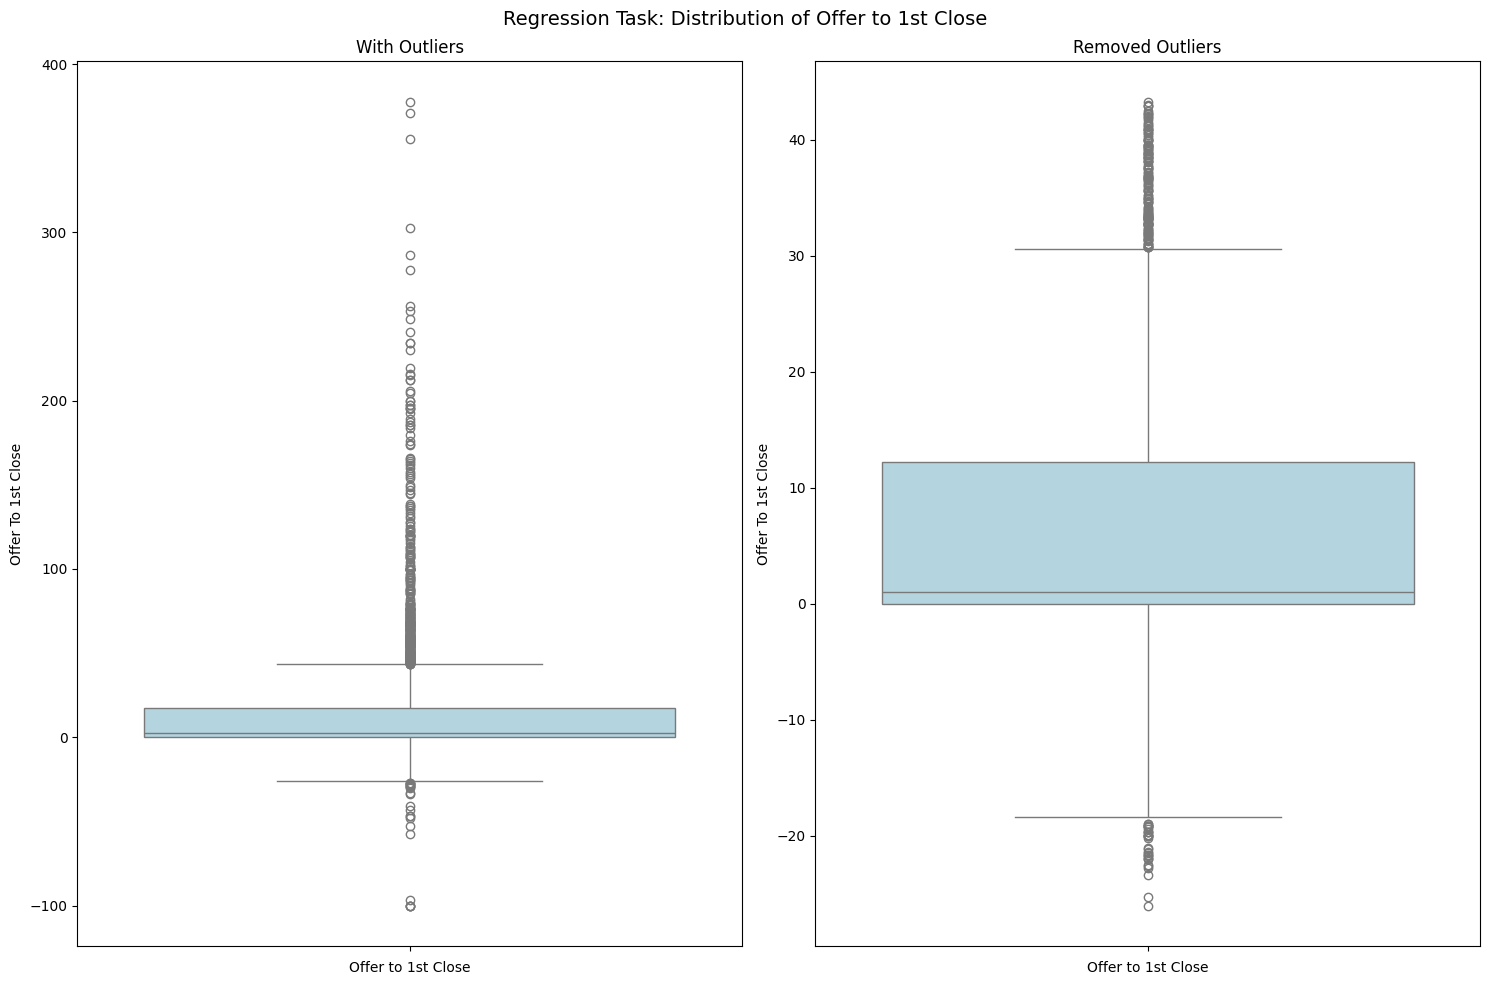

In [17]:
"""
Display distribution of target, after removing outliers. 
"""

df_no_outliers = df_dev_filtered.copy()
df_with_outliers = df_dev_correlation.copy()

fig, axs = plt.subplots(ncols=2, figsize=(15, 10))

sns.boxplot(data=df_with_outliers, y='Offer To 1st Close', color='lightblue', ax=axs[0])
axs[0].set_title('With Outliers')
axs[0].set_xlabel('Offer to 1st Close')

sns.boxplot(data=df_no_outliers, y='Offer To 1st Close', color='lightblue', ax=axs[1])
axs[1].set_title('Removed Outliers')
axs[1].set_xlabel('Offer to 1st Close')

fig.suptitle('Regression Task: Distribution of Offer to 1st Close', fontsize=14)
plt.tight_layout()
plt.show()


In [22]:
df_with_outliers[df_with_outliers['Offer To 1st Close']>0]['Offer To 1st Close'].count()

np.int64(2121)